#Acess Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset.zip 

Archive:  /content/drive/MyDrive/Dataset.zip
   creating: Dataset/
   creating: Dataset/Brain scans/
   creating: Dataset/Brain scans/No tumor/
   creating: Dataset/Brain scans/No tumor/Test/
  inflating: Dataset/Brain scans/No tumor/Test/no501.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no502.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no503.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no504.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no505.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no506.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no507.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no508.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no509.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no510.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no511.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no512.jpg  
  inflating: Dataset/Brain scans/No tumor/Test/no513.jpg  
  inflating: Dataset/Brain scans/No tumor

# import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from skimage import io
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')

import random

import glob
from IPython.display import display
from PIL import Image

# Read Dataset

In [ ]:
def Dataset(path):

    img_names = os.listdir(path)
    df = pd.DataFrame()
    df['img_name'] = img_names
    df['img_name_mask'] = img_names
    for idx, name in enumerate(img_names):
        
        img_name = path +'/'+ name
        img_name_mask =path+'_masks/'+name.replace('jp','pn')

        df['img_name'].iloc[idx] = img_name
        df['img_name_mask'].iloc[idx] = img_name_mask
    return df

In [ ]:
path ='/content/Dataset/Brain scans/Tumor/'
df_train = Dataset(path+'TRAIN')
df_test = Dataset(path+'TEST')

In [ ]:
df_test.shape

(100, 2)

# Visulization samples

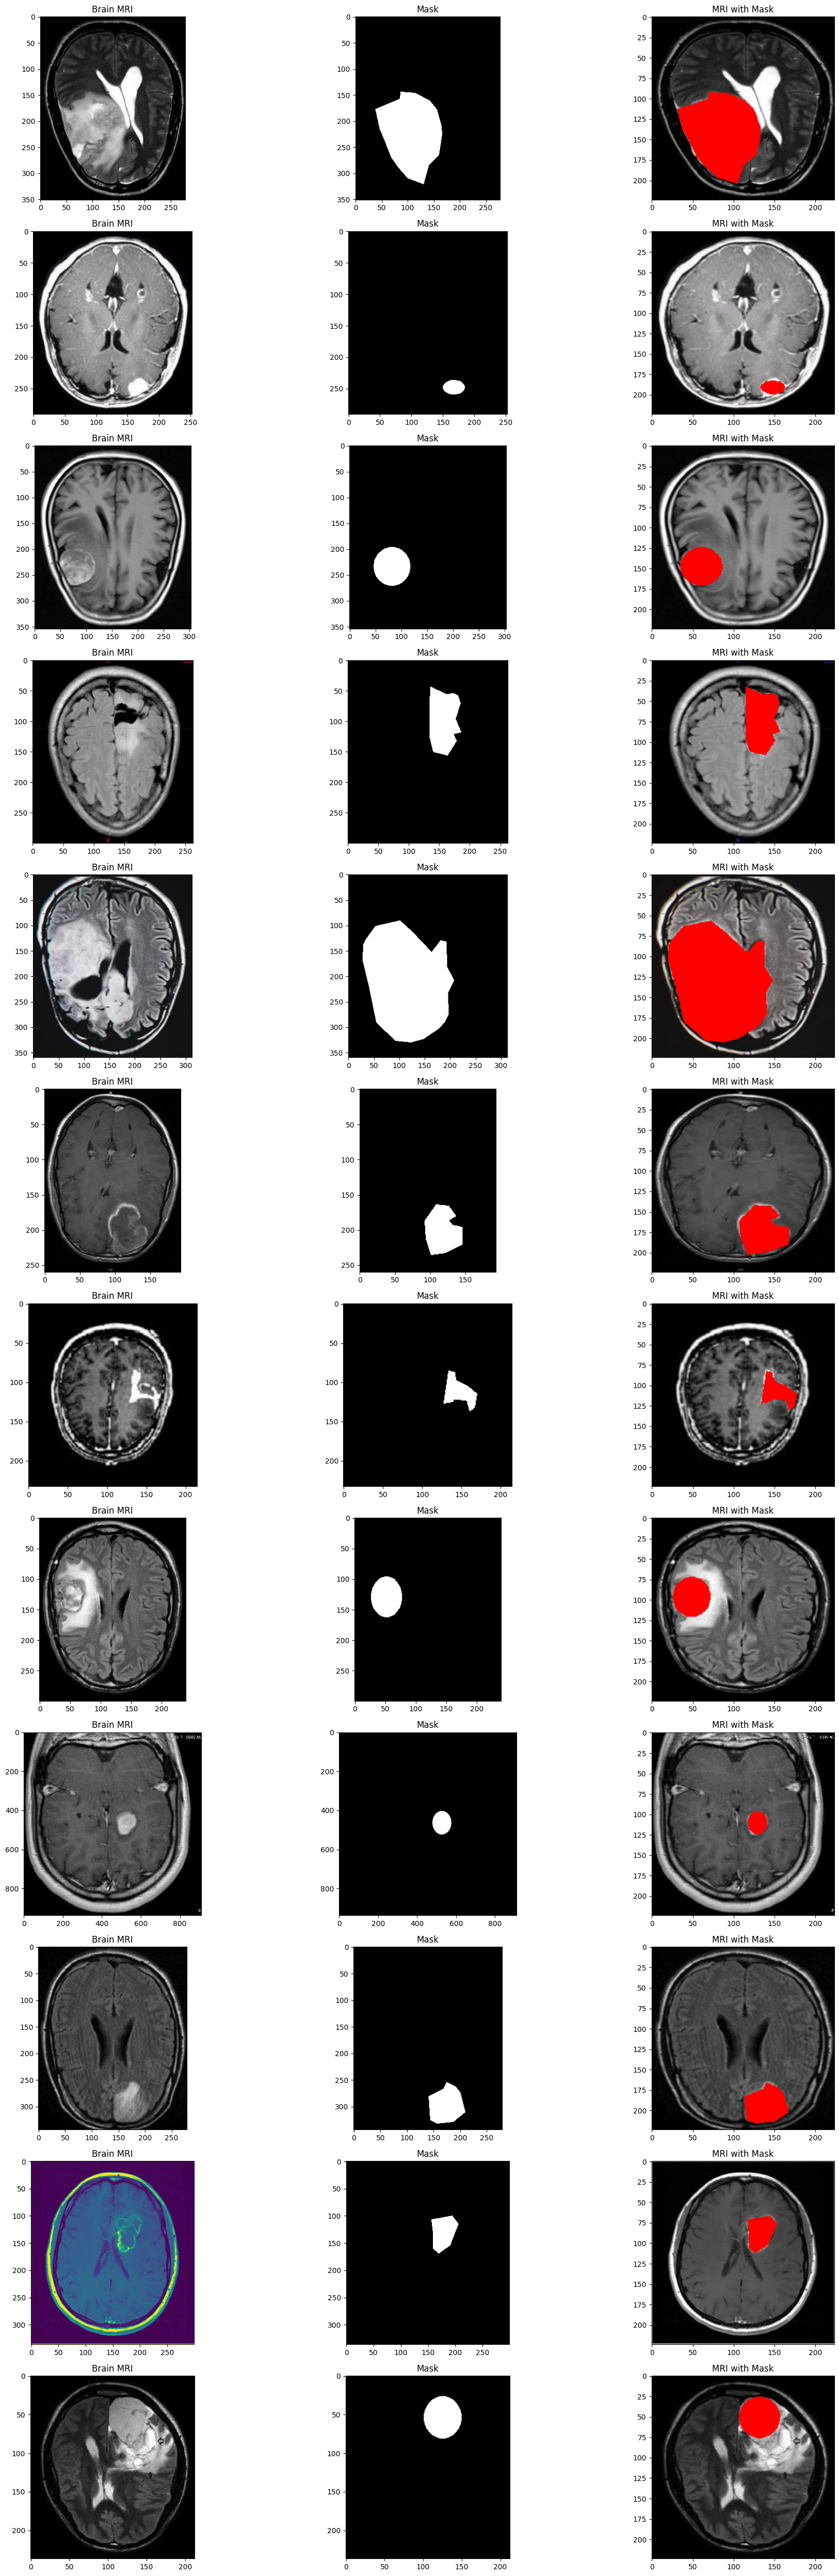

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize=(20, 50))
for i in range(12):
    img = io.imread(df.img_name[i])
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask = io.imread(df.img_name_mask[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap='gray')

    # Resize the mask to match the shape of the img array
    mask = cv2.imread(df.img_name_mask[i])

    #resizing and coverting them to array of type float64
    mask = cv2.resize(mask,(224, 224))


    # Resize the mask to match the shape of the img array
    img = cv2.imread((df.img_name[i]))

    #resizing and coverting them to array of type float64
    img = cv2.resize(img,(224, 224))

    # Create a copy of the original image to avoid modifying the original data
    img_with_mask = img.copy()

    # Create a mask that selects the masked positions in the image array
    mask_idx = np.where(mask == 255)

    # Assign the desired color values to the masked positions in the image array
    img_with_mask[mask_idx[0], mask_idx[1], :] = (255, 0, 0)

    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img_with_mask)
    count += 1

fig.tight_layout()


# DataGenerator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image

      img =  cv2.imread(img_path, cv2.IMREAD_COLOR)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #Normlize
      img = img /255

      mask = mask/255
 
      
      #Adding image to the empty array
      
      X[i,] = img
      
    
      y[i,] = np.expand_dims(mask, axis = 2)
      
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

In [ ]:
train_data = DataGenerator(df_train['img_name'], df_train['img_name_mask'],batch_size = 32, img_h = 224, img_w = 224, shuffle = True)
val_data = DataGenerator(df_test['img_name'], df_test['img_name_mask'],batch_size = 32, img_h = 224, img_w = 224, shuffle = False)

# U-net vgg

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
    
def build_vgg19_unet(input_shape):

    inputs = Input(input_shape)


    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    b1 = vgg19.get_layer("block5_conv4").output         

   
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      


    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [ ]:
model = build_vgg19_unet((224,224,3))
model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

# Custom Metric 


In [ ]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_path = '/content/drive/MyDrive/Models/'

In [ ]:
#compling model and callbacks functions
# adam = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.1)
# model.compile(optimizer = adam, 
#                   loss = focal_tversky, 
#                   metrics = [tversky]
#                  )
#callbacks
earlystopping = EarlyStopping(monitor='iou',
                              mode='max', 
                              verbose=1, 
                              patience=30,
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Models/Brain_model.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='iou',
                              mode='max',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient, iou,'accuracy'])

In [ ]:
history = model.fit(train_data, 
                  epochs = 40, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 0.5032 - dice_coefficient: 0.1510 - iou: 0.0819 - accuracy: 0.7923
Epoch 1: val_loss improved from inf to 1.47088, saving model to /content/drive/MyDrive/Models/Brain_model.h5
15/15 [==============================] - 58s 2s/step - loss: 0.5032 - dice_coefficient: 0.1510 - iou: 0.0819 - accuracy: 0.7923 - val_loss: 1.4709 - val_dice_coefficient: 4.0036e-04 - val_iou: 2.0552e-04 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.2322 - dice_coefficient: 0.2086 - iou: 0.1167 - accuracy: 0.9543
Epoch 2: val_loss improved from 1.47088 to 0.29342, saving model to /content/drive/MyDrive/Models/Brain_model.h5
15/15 [==============================] - 27s 2s/step - loss: 0.2322 - dice_coefficient: 0.2086 - iou: 0.1167 - accuracy: 0.9543 - val_loss: 0.2934 - val_dice_coefficient: 0.0919 - val_iou: 0.0482 - val_accuracy: 0.9334 - lr: 0.0010
Epoch 3/40
15/15 [==================

In [ ]:
model.evaluate(val_data)

3/3 [==============================] - 1s 405ms/step - loss: 0.0919 - dice_coefficient: 0.5267 - iou: 0.3588 - accuracy: 0.9656


[0.09192138910293579,
 0.5266885161399841,
 0.3587673008441925,
 0.9656027555465698]

# Custom loss & Metric


In [ ]:
import keras.backend as K

def dice_iou_loss(y_true, y_pred):
    """
    Custom loss function that combines the Dice coefficient and Intersection over Union (IoU) metrics.
    """
    epsilon = 1e-6
    
    # Flatten the true and predicted tensors
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Cast y_true_f and y_pred_f to float32
    y_true_f = K.cast(y_true_f, dtype='float32')
    y_pred_f = K.cast(y_pred_f, dtype='float32')
    
    # Calculate the Dice coefficient
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coefficient = (2.0 * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)
    
    # Calculate the IoU
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    
    # Combine the Dice coefficient and IoU as the final loss
    loss = 1.0 - (dice_coefficient + iou) / 2.0
    
    return loss 



In [ ]:
model = build_vgg19_unet((224,224,3))
model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [ ]:
model.compile(optimizer='adam', loss=dice_iou_loss, metrics=['accuracy', dice_coefficient, iou])

In [ ]:

history = model.fit(train_data, 
                  epochs = 100, 
                  validation_data = val_data,
                  callbacks = [earlystopping, reduce_lr]
                 )

Epoch 1/100
15/15 [==============================] - 35s 2s/step - loss: 0.8036 - accuracy: 0.8076 - dice_coefficient: 0.2489 - iou: 0.1438 - val_loss: 0.9021 - val_accuracy: 0.2768 - val_dice_coefficient: 0.1277 - val_iou: 0.0682 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 22s 1s/step - loss: 0.7010 - accuracy: 0.9248 - dice_coefficient: 0.3699 - iou: 0.2281 - val_loss: 0.9222 - val_accuracy: 0.0537 - val_dice_coefficient: 0.1020 - val_iou: 0.0537 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 21s 1s/step - loss: 0.6248 - accuracy: 0.9489 - dice_coefficient: 0.4550 - iou: 0.2954 - val_loss: 0.9221 - val_accuracy: 0.0538 - val_dice_coefficient: 0.1020 - val_iou: 0.0537 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 22s 1s/step - loss: 0.5782 - accuracy: 0.9536 - dice_coefficient: 0.5044 - iou: 0.3392 - val_loss: 0.9569 - val_accuracy: 0.4139 - val_dice_coefficient: 0.0569 - val_iou: 0.0293 - lr: 0.0010
Epoch 5/100
15/15 [=====

In [ ]:
model.save("/content/drive/MyDrive/Models/Brain_model.h5")

In [ ]:
model.evaluate(val_data)

3/3 [==============================] - 1s 415ms/step - loss: 0.2775 - accuracy: 0.9783 - dice_coefficient: 0.7902 - iou: 0.6548


[0.2774641513824463, 0.978291392326355, 0.7902376055717468, 0.6548388004302979]

# Define a custom loss function

In [ ]:
#Define a custom loss function for Vgg19 UNet model
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

adam = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.1)
model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='iou',
                              mode='max', 
                              verbose=1, 
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Models/Brain_model.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='iou',
                              mode='max',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
model.fit(train_data, 
                  epochs = 40, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 0.8915 - tversky: 0.1419
Epoch 1: val_loss improved from inf to 0.90880, saving model to /content/drive/MyDrive/Models/Brain_model.h5
15/15 [==============================] - 40s 2s/step - loss: 0.8915 - tversky: 0.1419 - val_loss: 0.9088 - val_tversky: 0.1197 - lr: 0.0010
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.8768 - tversky: 0.1608
Epoch 2: val_loss improved from 0.90880 to 0.88994, saving model to /content/drive/MyDrive/Models/Brain_model.h5
15/15 [==============================] - 28s 2s/step - loss: 0.8768 - tversky: 0.1608 - val_loss: 0.8899 - val_tversky: 0.1440 - lr: 0.0010
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.8609 - tversky: 0.1810
Epoch 3: val_loss improved from 0.88994 to 0.87219, saving model to /content/drive/MyDrive/Models/Brain_model.h5
15/15 [==============================] - 27s 2s/step - loss: 0.8609 - tversky: 0.1810 - val_loss: 0.8722 -

In [ ]:
# y_true =[]
# # Option 2: Iterating over the generator to get all batches
# for _, (x_val, y_val) in enumerate(val_data):
#     y_true.append(y_val)

# # Convert list to NumPy array
# y_true = np.array(y_true)

In [ ]:
y_pred = model.predict(val_data)

3/3 [==============================] - 1s 430ms/step


In [ ]:
# def dice_coefficient(y_true, y_pred, smooth=1):
#     """
#     Dice coefficient implementation.
    
#     Parameters:
#         y_true (array): Ground truth segmentation mask.
#         y_pred (array): Predicted segmentation mask.
#         smooth (float): Smoothing term to avoid division by zero.
        
#     Returns:
#         float: Dice coefficient value.
#     """
#     y_true = y_true.flatten()
#     y_pred = y_pred.flatten()
#     intersection = np.sum(y_true * y_pred)
#     dice = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
#     return dice

# def iou(y_true, y_pred, smooth=1e-7):
#     """
#     Intersection over Union (IoU) implementation.
    
#     Parameters:
#         y_true (array): Ground truth segmentation mask.
#         y_pred (array): Predicted segmentation mask.
#         smooth (float): Smoothing term to avoid division by zero.
        
#     Returns:
#         float: IoU value.
#     """
#     y_true = y_true.flatten()
#     y_pred = y_pred.flatten()

#     intersection = np.sum(y_true * y_pred)
#     union = np.sum(y_true) + np.sum(y_pred) - intersection
#     iou = (intersection + smooth) / (union + smooth)
#     return iou


In [ ]:
# dice = dice_coefficient(y_true, y_pred)
# iou = iou(y_true, y_pred)
# print("Dice coefficient:", dice)
# print("IoU:", iou)

Dice coefficient: 0.2595456868883678
IoU: 0.14912490319894053


# Pure U-net Implememtion


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet(input_shape=(256, 256, 1), n_classes=2):
    # Encoder
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    up5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    merge5 = Concatenate(axis=3)([conv3, up5])

    up6 = UpSampling2D(size=(2, 2))(merge5)
    up6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    up6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    merge6 = Concatenate(axis=3)([conv2, up6])

    up7 = UpSampling2D(size=(2, 2))(merge6)
    up7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    up7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    merge7 = Concatenate(axis=3)([conv1, up7])

    # Output layer
    output = Conv2D(n_classes, 1, activation='sigmoid')(merge7)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Define U-Net model
model = unet(input_shape=(224, 224, 3), n_classes=1) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])

In [ ]:
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Models/Brain_model_v2.h5", 
                               verbose=1, 
                               save_best_only=True
                              )


In [ ]:
history = model.fit(train_data, 
                  epochs = 20, 
                  validation_data = val_data,
                  batch_size = 32,
                  callbacks = [earlystopping, reduce_lr]
                 )

Epoch 1/20


## Create Model

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
    
def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model


# Load model

In [ ]:
def calculate_mask_dimensions(mask):

    mask = mask.reshape(224,224)*255
    image = Image.fromarray(mask.astype('uint8'))
    image.save('output_image.jpg')
    mask =  cv2.imread('output_image.jpg', cv2.IMREAD_GRAYSCALE)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("No contours found.")
        return None, None

    # Get bounding box
    x, y, width, height = cv2.boundingRect(contours[0])

    return height, width


In [ ]:
#the custom loss function & Metric
custom_objects = {'dice_iou_loss': dice_iou_loss,'dice_coefficient': dice_coefficient,'iou': iou}

# Load the model with the custom loss function & Metric
model = load_model("/content/drive/MyDrive/Models/Brain_model.h5", custom_objects=custom_objects)


In [ ]:
def prediction(path_img, model):
    # making prediction
    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1,224,224,3))
    #resizing the image and coverting them to array of type float64
    img =  cv2.imread(path_img, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224,224))
    img = np.array(img, dtype=np.float64)

    # standardising the image
    img = img/225
    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction of mask
    pred = model.predict(X)

    return pred


In [ ]:
def visualization_comparison(pred_mask, orginal_mask, path_img):


    fig, axs = plt.subplots(2, 2, figsize=(8, 12))

    # Resize the mask to match the shape of the img array
    img = cv2.imread(path_img)

    #resizing and coverting them to array of type float64
    img = cv2.resize(img,(224, 224))

    axs[0][0].title.set_text("Brain MRI")
    axs[0][0].imshow(img)

    # Resize the mask to match the shape of the img array
    mask = cv2.imread(orginal_mask)

    #resizing and coverting them to array of type float64
    mask = cv2.resize(mask,(224, 224))




    # Create a copy of the original image to avoid modifying the original data
    img_with_mask = img.copy()

    # Create a mask that selects the masked positions in the image array
    mask_idx = np.where(mask == 255)

    # Assign the desired color values to the masked positions in the image array
    img_with_mask[mask_idx[0], mask_idx[1], :] = (255, 0, 0)


    axs[0][1].title.set_text("MRI with Mask")
    axs[0][1].imshow(img_with_mask)


    axs[1][0].title.set_text("Brain MRI")
    axs[1][0].imshow(img)

   
    pred_mask = cv2.resize(pred_mask,(224, 224))

    img_with_pred_mask = img.copy()
    mask_idx = np.where(pred_mask ==1)
     # Assign the desired color values to the masked positions in the image array
    img_with_pred_mask[mask_idx[0], mask_idx[1], :] = (255, 0, 0)

    axs[1][1].title.set_text("MRI with Predicated Mask")
    axs[1][1].imshow(img_with_pred_mask)



    fig.tight_layout()

In [ ]:
def visualization(pred_mask, path_img):


    fig, axs = plt.subplots(1, 2, figsize=(8, 12))

    # Resize the mask to match the shape of the img array
    img = cv2.imread(path_img)

    #resizing and coverting them to array of type float64
    img = cv2.resize(img,(224, 224))

    axs[0].title.set_text("Brain MRI")
    axs[0].imshow(img)

     #resizing and coverting them to array of type float64
    pred_mask = pred_mask.reshape(224,224,1)
    pred_mask = cv2.resize(pred_mask,(224, 224))

    img_with_pred_mask = img.copy()
    mask_idx = np.where(pred_mask ==1)
     # Assign the desired color values to the masked positions in the image array
    img_with_pred_mask[mask_idx[0], mask_idx[1], :] = (255, 0, 0)

    axs[1].title.set_text("MRI with Predicated Mask")
    axs[1].imshow(img_with_pred_mask)



    fig.tight_layout()

In [ ]:
path_img = df_test['img_name'][80]
orginal_mask = df_test['img_name_mask'][80]
pred_mask = None

In [ ]:
pred_mask= prediction(path_img, model)

1/1 [==============================] - 0s 24ms/step


In [ ]:
height, width = calculate_mask_dimensions(pred_mask)
print('height = ', height)
print('width = ', width)

height =  35
width =  38


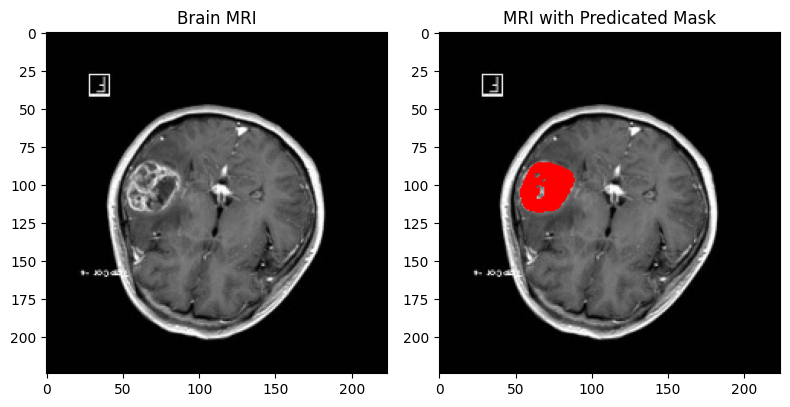

In [ ]:
visualization(pred_mask, path_img)

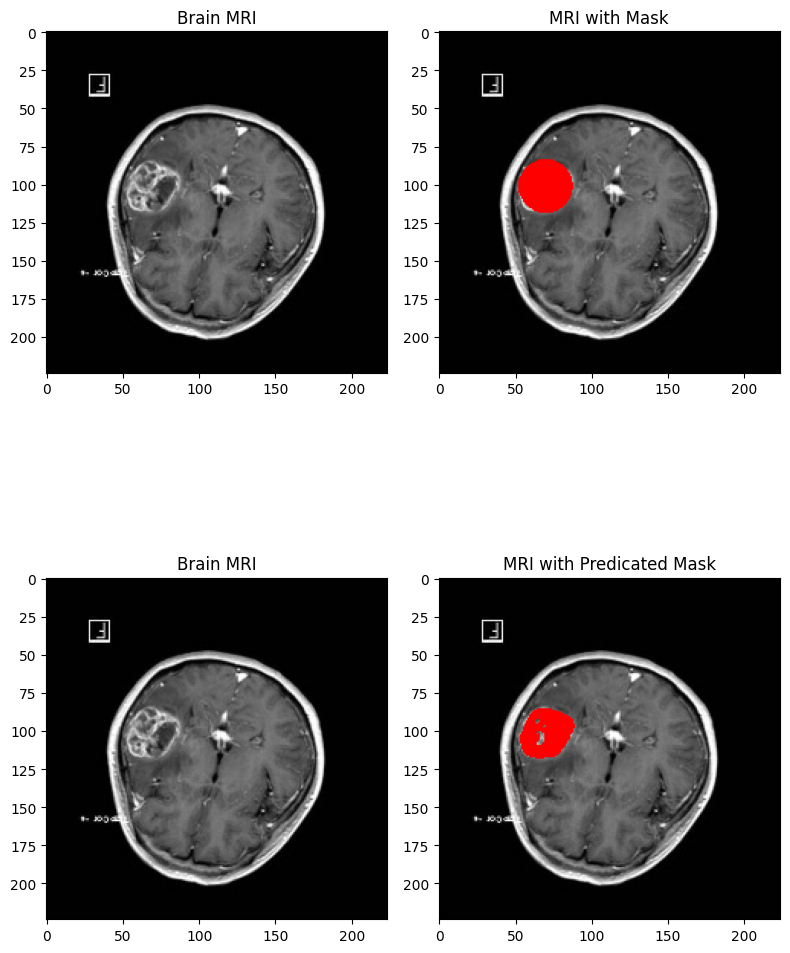

In [ ]:
visualization_comparison(pred_mask, orginal_mask, path_img)